In [1]:
import numpy as np
from time import time
from math import log, sqrt, exp
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score

import statsmodels.api as sm

In [2]:
# 计算的一些初始值
S_0 = 10.0    # 股票或指数初始的价格;
T = 2        #  股票价格观测年限
r = 0.05       #   无风险利率

lamda = 1    # 影响波动率的固定部分
theta = -0.53    # 杠杆效应
miu = 0     # 股票价格的漂移项 ，先假设为0
N = 420     # number of time steps 210个区间
dt = T/N       # time enterval
I = 20000       # number of simulation


In [3]:
Me=np.mat([[1,2],[3,4],[5,6]])
print(Me.shape)
Me[:,0]

(3, 2)


matrix([[1],
        [3],
        [5]])

In [4]:
np.random.seed(2000)
#C_0=[]
#Zi=np.zeros(shape=(M+1,I))
#S_ie=np.zeros(shape=(M+1,I)) # 表示EMS方法处理过后的资产价格
S_i=np.zeros(shape=(N+1,I)) #股票价格有211天的数据
S_i[0]=S_0
start = time()
for t in range (N): # 一条路径上的节点数
    
    # 生成一个随机变量的数组，N+1行，I列
    # 同时计算出每一条路径，每一个时间点的指数水平的增量
    # np.cumsum(axis=0)，在列的方向上进行累加得到每一个时间步数上的指数水平
    #S_i = S_0 * np.exp(np.cumsum((miu) *dt +sigma *np.sqrt(dt) *np.random.standard_normal((M+1, I)),axis=0))
    for i in range (I):
        S_i[t+1,i] =  S_i[t,i]* np.exp((miu-0.5*(lamda*S_i[t,i]**theta)**2) *dt +lamda*S_i[t,i]**(theta)*np.sqrt(dt) *np.random.standard_normal((1, 1)))
        #S_i[t+1,i] = S_i[t,i]+ (miu*S_i[t,i] +0.5*lamda**2*(theta+1)*S_i[t,i]**(2*theta+1))*dt+lamda*S_i[t,i]**(theta+1)*np.sqrt(dt)*np.random.standard_normal((1, 1))
       # S_ie[0]=S_0
        # 行数代表时间，列数代表第几个模拟值
        #for m in range(M):
       #     Zi[m]=S_ie[m]*np.array(S_i[m+1])/np.array(S_i[m])
      #      Z0=np.exp(-r * T)* np.sum(Zi[m])/I
     #       S_ie[m+1]=(S_0*Zi[m]/Z0)          
    #    C_0.append(np.exp(-r * T) * np.sum(np.maximum(np.mat(S_ie)[-1] - K, 0))/I)


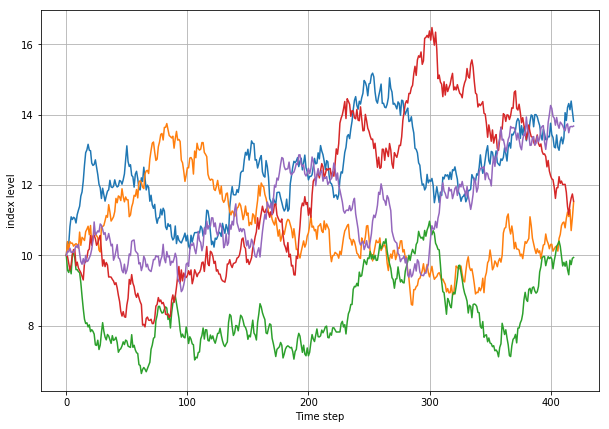

In [5]:
# 前２０条模拟路径

%matplotlib inline 
plt.figure(figsize=(10,7))
plt.grid(True)
plt.xlabel('Time step')
plt.ylabel('index level')
plt.plot(S_i[:N,:5])
plt.show()

In [6]:
#Estimation
#Estimate the standard deviation.

K=21  #方差估计的窗口期
sigma_hat=np.zeros(shape=(N-K+2,I)) #Because we do not estimate the s.d. of the first 10 and the last 10 days.初始化
r=np.zeros(shape=(N,I))    # r表示回报率
for n in range(N):
    r[n]=np.log(np.array(S_i[n+1])/np.array(S_i[n])) #对数化求return
    #r[n]=((np.array(S_i[n+1]))/np.array(S_i[n]))-1 #常规return
    
for t in range(N-K+2):
    for i in range(I):
        sigma_hat[t,i]=sqrt(sum((r[t:t+K-1,i]-sum(r[t:t+K-1,i])/K)**2)/(K-1))  
        #sigma_hat[t,i]=sqrt(sum(r[t:t+K-1,i]**2)+2*sum(r[t:t+K-2,i]*r[t+1:t+K-1,i])/(K-1))


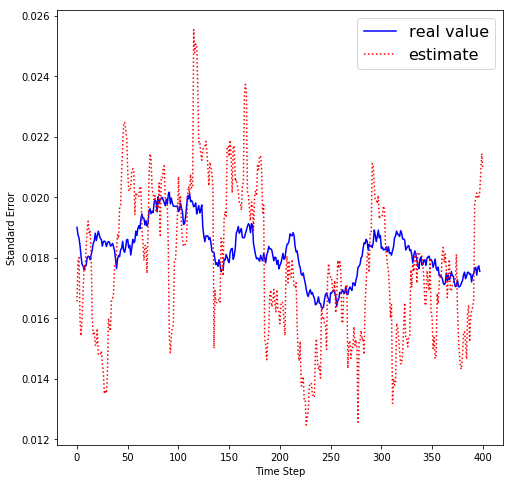

In [7]:
#Compare the estimates and the real value of standard deviation.

from collections import OrderedDict
sigma=lamda*S_i**(theta)*sqrt(dt)

a=int((K+1)/2)
b=N-int(a)
plt.figure(figsize=(8,8))
plt.xlabel('Time Step')
plt.ylabel('Standard Error')
plt.plot(sigma[a:b,:1],label='real value',color='b',linestyle='-')
plt.plot(sigma_hat[:,:1],label='estimate',color='r',linestyle=':')
handles, labels = plt.gca().get_legend_handles_labels()    ##这里是为了删去重复的图例
by_label = OrderedDict(zip(labels, handles))               ##
plt.legend(by_label.values(), by_label.keys(),fontsize=16)
plt.show()

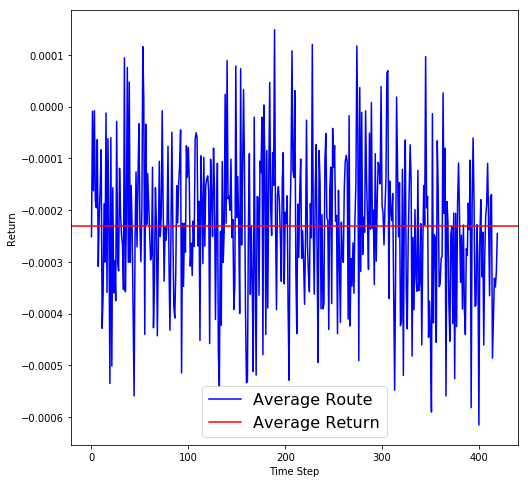

In [8]:
#回报率路径图

from collections import OrderedDict
sigma=lamda*S_i**(theta)*sqrt(dt)

a=int((K+1)/2)
b=N-int(a)
plt.figure(figsize=(8,8))
plt.xlabel('Time Step')
plt.ylabel('Return')
r_aver=np.sum(r,axis=1)/I
geo_mean=np.exp(np.average(np.log(1+r_aver)))-1
plt.plot(r_aver,label='Average Route',color='b',linestyle='-')
plt.axhline(y=geo_mean,label='Average Return',color='red',linestyle='-')
handles, labels = plt.gca().get_legend_handles_labels()    ##这里是为了删去重复的图例
by_label = OrderedDict(zip(labels, handles))               ##
plt.legend(by_label.values(), by_label.keys(),fontsize=16)
plt.show()

In [9]:
print(a,b)

11 409


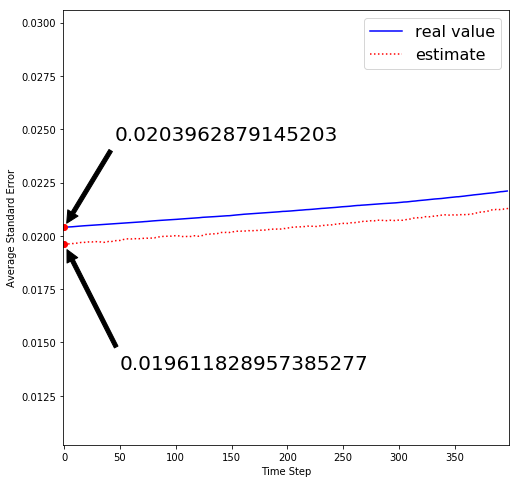

0.0203962879145203 0.019611828957385277 0.038460868978838006


In [10]:
### add Annotating text
Ave_sigma=np.sum(sigma,axis=1)/I
Ave_sigma_hat=np.sum(sigma_hat,axis=1)/I
fig=plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.annotate(Ave_sigma[a], xy=(0,Ave_sigma[a] ), xytext=(45,Ave_sigma[a]*1.2 ),size=20,
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
ax.annotate(Ave_sigma_hat[0], xy=(0, Ave_sigma_hat[0]), xytext=(50, Ave_sigma_hat[0]*0.7),size = 20,
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
ax.set_ylim(Ave_sigma[a]*0.5,Ave_sigma[a]*1.5)
ax.set_xlim(-1,N-K)

### Create the figure

plt.xlabel('Time Step')
plt.ylabel('Average Standard Error')

plt.plot(Ave_sigma[a:b],label='real value',color='b',linestyle='-')
plt.plot(Ave_sigma_hat,label='estimate',color='r',linestyle=':')
line,=ax.plot(0,Ave_sigma[a],'r-o')
line,=ax.plot(0,Ave_sigma_hat[0],'r-o')
plt.legend(fontsize=16,loc=1)
plt.show()
print(Ave_sigma[a],Ave_sigma_hat[0],(Ave_sigma[a]-Ave_sigma_hat[0])/Ave_sigma[a])

-0.0517317341327438 0.16722065833068456 (401, 20000)


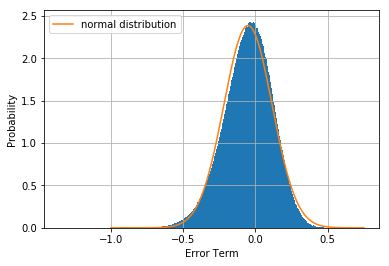

In [11]:
# 到期时所有模拟指数水平的频率直方图
# 误差项的频率分布图
import matplotlib.pyplot as plt
%matplotlib inline
error=np.log(sigma_hat[:,:])-np.log(sigma[a-1:b+2,:])
plt.hist(error.flatten(), bins=1000,density=True)
plt.grid(True)
plt.xlabel('Error Term')
plt.ylabel('Probability')
print(np.average(error),np.std(error,ddof=1),error.shape)
def normfun(x,mu,sigma):
    pdf = np.exp(-((x - mu)**2)/(2*sigma**2)) / (sigma * np.sqrt(2*np.pi))
    return pdf
x = np.arange(-1,0.75,0.001) 
#设定 y 轴，载入刚才的正态分布函数
y = normfun(x, np.average(error), np.std(error,ddof=1))
plt.plot(x,y,label='normal distribution')
#plt.axvline(x=bsm_call_value(S_0, K, T, r, sigma),ls=":",c="yellow")#真实值
#plt.axvline(x=np.average(error.flatten()),label='average line',ls="-",c="green")#样本均值
plt.legend(fontsize=10,loc=2)
plt.show()

In [12]:
##单位根检验
##第一步 构造ut
#u_t=(error[1:,:]-error[:-1,:])
u_t=error
print(u_t[:,:1].shape)
##第二步 用ADF检验
t_adf=[]
for i in range(I):
    adf=sm.tsa.stattools.adfuller(u_t[:,i].flatten())
    t_adf.append(adf[0])
print(np.max(t_adf),np.median(t_adf),np.min(t_adf),np.mean(t_adf))
print(adf)

(401, 1)
-1.895612182882928 -3.8350797391843616 -7.851918166330339 -3.9375127148596687
(-4.216065753211218, 0.0006188332544767763, 11, 389, {'1%': -3.447272819026727, '5%': -2.868998737588248, '10%': -2.5707433189709294}, -1128.1851652134142)


In [13]:
##P值表格
p_adf=[]
for i in range(I):
    adf=sm.tsa.stattools.adfuller(u_t[:,i].flatten())
    p_adf.append(adf[1])
print(np.max(p_adf),np.median(p_adf),np.min(p_adf),np.mean(p_adf))

0.3341280855942643 0.0025681198787331034 5.5717925278379265e-12 0.008705011055984075


In [14]:
p_adf.sort()
n=0
while (p_adf[n]<0.01):
    n=n+1
print(n/I)

0.7609


In [15]:
##ut作图
#fig=plt.figure(figsize=(8,8))
#ax = fig.add_subplot(111)
#ax.set_xlim(-0.5,0.5)

#plt.hist(u_t.flatten(), bins=1000,density=True)
#plt.grid(True)
#plt.xlabel('u_t')
#plt.ylabel('Probability')
#x = np.arange(-0.25,0.25,0.001) 
##设定 y 轴，载入刚才的正态分布函数
#y = normfun(x, np.average(u_t), np.std(u_t,ddof=1))
#plt.plot(x,y,label='normal distribution')
#plt.legend(fontsize=10,loc=2)
#plt.show()
#print(np.average(u_t),np.std(u_t,ddof=1),u_t.shape)

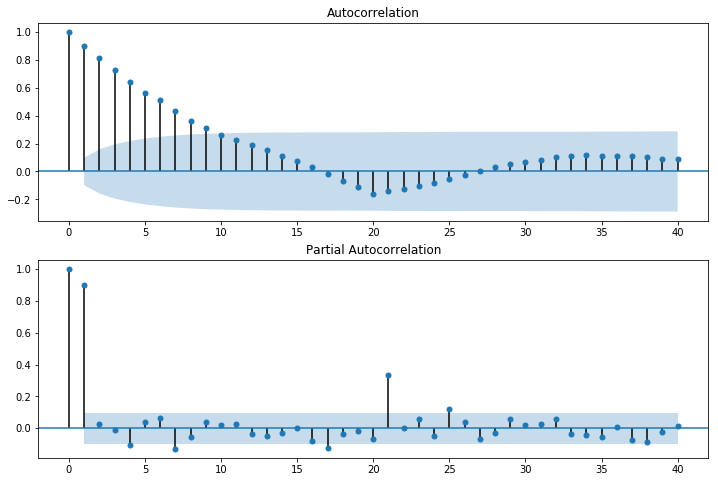

In [16]:
#dta= dta.diff(1)#我们已经知道要使用一阶差分的时间序列，之前判断差分的程序可以注释掉
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(u_t[:,:1],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(u_t[:,:1],lags=40,ax=ax2)
#————————————————


In [17]:
##Least Square
##The second step
#Y=np.log((sigma_hat[1:,:]/sigma_hat[:-1,:]))##差分后
Y=np.log(sigma_hat)##差分前
#X=r[a-1:b+1,:]##差分后
X=np.log(S_i[a-1:b+2,:])##差分前

In [18]:
print(Y.shape,X.shape)
lrModel = LinearRegression()

(401, 20000) (401, 20000)


In [19]:
beta=np.zeros(shape=(I,2))
t=np.zeros(shape=(I,2))
for i in range(I):
    model=sm.GLS(Y[:,i],sm.add_constant(X[:,i])).fit(cov_type='HC0')
    #model=sm.OLS(Y[:,i],sm.add_constant(X[:,i])).fit(cov_type='HC0')
    beta[i]=model.params
    t[i]=model.tvalues
    
b0=[t[:,0],beta[:,0]]
b1=[t[:,1],beta[:,1]]


In [20]:
np.array(b0).shape

(2, 20000)

In [21]:
b0=np.array(b0)
b1=np.array(b1)

(2, 20000) 16.466855761983172 -10.12779646588136 -77.44470893792243 -11.12892419256837
1.7278014496572105 -0.5091525212358188 -1.966128746313387 -0.5000003773792026 0.2708923325598208
MSE= 0.07428263319709082


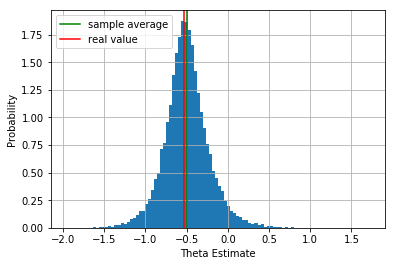

In [22]:
#theta_hat的20000次回归结果，从小到大排序
plt.hist((b1[1,:]), bins=100,density=True)
plt.grid(True)
plt.xlabel('Theta Estimate')
plt.ylabel('Probability')
plt.axvline(x=np.average((b1[1,:])),label='sample average',ls="-",c="green")
plt.axvline(x=theta,label='real value',ls="-",c="red")
print(b1.shape,np.max(b1[0,:]),np.median(b1[0,:]),np.min(b1[0,:]),np.mean(b1[0,:]))##t-value
print(np.max(b1[1,:]),np.median(b1[1,:]),np.min(b1[1,:]),np.mean(b1[1,:]),np.std(b1[1,:],ddof=1))##beta
print("MSE=",np.std(b1[1,:],ddof=1)**2+(theta-np.mean(b1[1,:]))**2)
plt.legend(fontsize=10,loc=2)
plt.show()

In [23]:
end = time()
time_elapsed = end-start
print('The code run {:.0f}minutes {:.0f}seconds'.format(
        time_elapsed // 60, time_elapsed % 60))

The code run 12minutes 42seconds
